In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from google.colab import drive
from IPython.display import clear_output
from sklearn.metrics import f1_score
from torch.utils.data import Dataset
from transformers import BertConfig, BertModel, BertTokenizer, PreTrainedModel

In [ ]:
drive.mount('/content/drive')

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
data.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [4]:
categories = {}
for n, cat in enumerate(np.unique(data["category"])):
    categories[cat] = n
len(categories)

77

In [5]:
data['len'] = data["text"].apply(len)
data["lowered"] = data['text'].apply(str.lower)
data['label'] = data['category'].apply(lambda x: categories[x])
data.head()

,text,category,len,lowered,label
0,I am still waiting on my card?,card_arrival,30,i am still waiting on my card?,12
1,What can I do if my card still hasn't arrived ...,card_arrival,60,what can i do if my card still hasn't arrived ...,12
2,I have been waiting over a week. Is the card s...,card_arrival,58,i have been waiting over a week. is the card s...,12
3,Can I track my card while it is in the process...,card_arrival,59,can i track my card while it is in the process...,12
4,"How do I know if I will get my card, or if it ...",card_arrival,54,"how do i know if i will get my card, or if it ...",12


In [6]:
np.bincount(data['label'])

array([162, 159, 110, 126,  87, 127, 171, 181, 156, 157, 129,  59, 153,
       112, 139, 112, 187, 168, 167,  61, 177, 160, 122,  86,  35, 129,
       153, 173, 133, 182, 121, 121, 121, 112, 118, 166, 137, 126,  97,
       106, 129,  98,  82, 121, 120, 105, 159, 143, 149, 148, 115,  95,
       169, 161, 129, 108, 111, 114, 114, 145,  97, 146, 103, 175, 172,
       113, 171, 128, 102, 104, 113, 126,  41, 135, 121, 180, 163])

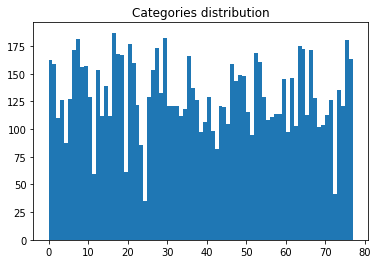

In [7]:
plt.title('Categories distribution')
plt.hist(data['label'], bins=np.arange(78))
plt.show()

In [8]:
data = data.sort_values(by=['len'], ignore_index=True)
# data = data.sample(frac=1).reset_index(drop=True)

*Здесь нужно будет порешать вопрос с несбалансированностью классов*

In [9]:
class CustomTextDataset(Dataset):
    def __init__(self, texts, labels, device):
        self.texts = texts
        self.labels = labels
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.texts[idx]
        sample = {"Text": text, "Label": label}
        return sample

    def get_batches(self, batch_size):

        device = self.device
        batches = []
        i = 0

        while i < len(self.texts):
            texts = self.texts[i : i + batch_size].tolist()
            labels = self.labels[i : i + batch_size].tolist()
            tokenized = tokenizer.prepare_seq2seq_batch(texts, return_tensors='pt')
            input_ids = tokenized.input_ids.to(device)
            mask = tokenized.attention_mask.to(device)
            labels = torch.LongTensor(labels).to(device)
            batch = {"input": input_ids, "mask": mask, "label": labels}
            batches.append(batch)
            i += batch_size

        return batches

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dataset = CustomTextDataset(data["lowered"], data["label"], device)
batches = dataset.get_batches(batch_size=128)

*Добавить Self-adjusting Dice Loss*

In [11]:
class BertForMultiLabelClassification(PreTrainedModel):
    def __init__(self, config=BertConfig(), num_labels=2):
        super(BertForMultiLabelClassification, self).__init__(config)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        pooler_output = self.bert(input_ids, attention_mask, token_type_ids).pooler_output
        pooler_output = self.dropout(pooler_output)
        logits = self.classifier(pooler_output)

        if labels is not None:
            loss_func = torch.nn.CrossEntropyLoss()
            loss = loss_func(logits, labels)
            return loss
        else:
            return logits

    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False

    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True

In [ ]:
bert_classifier = BertForMultiLabelClassification(num_labels=77)
bert_classifier.freeze_bert_encoder()

In [13]:
torch.cuda.empty_cache()
bert_classifier.to(device)
print(device)

cuda


In [14]:
bert_classifier.load_state_dict(torch.load('/content/drive/My Drive/classifier.pt'))

<All keys matched successfully>

In [15]:
def train(model, batches, optimizer, device=device, n_epochs=100):

    model.train()
    history = []

    for n in range(n_epochs):

        epoch_loss = 0
        for batch in batches:

            input, mask, labels = batch["input"], batch["mask"], batch["label"]

            optimizer.zero_grad()

            loss = model(input, mask, labels=labels)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        history.append(epoch_loss / len(batches))

        clear_output(True)
        plt.figure(figsize=(16, 8))
        plt.plot(history, label='train loss')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Train loss', fontsize=12)
        plt.title('Train loss', fontsize=14)
        plt.legend()
        plt.show()

    torch.save(model.classifier.state_dict(), '/content/drive/My Drive/classifier.pt')

    model.train(False)
    return

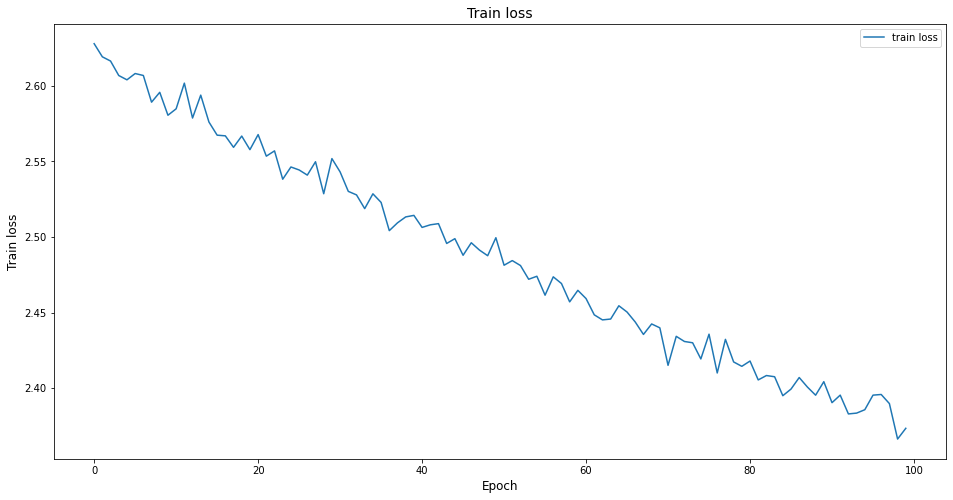

In [16]:
optimizer = torch.optim.Adam(bert_classifier.parameters(), lr=0.0001)
train(bert_classifier, batches, optimizer)

**Evaluation**

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
test_data = test_data.sample(frac=1).reset_index(drop=True)

texts = data['text'].apply(str.lower)
labels = data['category'].apply(lambda x: categories[x])

dataset = CustomTextDataset(texts, labels, device)
batches = dataset.get_batches(batch_size=40)

In [23]:
y_pred, y_true = [], []
for batch in batches:
    input, mask, labels = batch["input"], batch["mask"], batch["label"]
    with torch.no_grad():
        res = bert_classifier(input, mask)
    y_pred += res.argmax(dim=-1).cpu().tolist()
    y_true += labels.cpu().tolist()
print(f1_score(y_true, y_pred, average='micro'))

0.5862241327601719


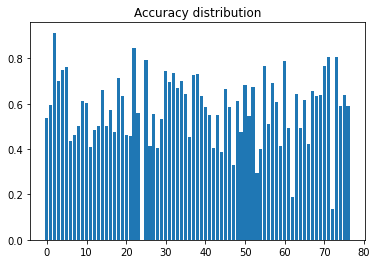

In [24]:
accuracy = f1_score(y_true, y_pred, average=None)
plt.title('Accuracy distribution')
plt.bar(np.arange(77), accuracy)
plt.show()

**Замечание.** В тестовой выборке все классы были представлены равномерно. Таким образм, можно заметить тенденцию, что при использовании семплинга батчей без ребалансировки классов точность предзказания для редких классов (почти) равна нулю.